# IV - Transferencia de Aprendizaje (a)

## Importar librerias

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf


# Importamos el modelo de ResNet50 y la utilidad preprocess_input_generation
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ImageDataGenerator es la clase que necesitamos para hacer la aumentación de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modelo del tipo secuencial
from tensorflow.keras.models import Model, Sequential

# Serie de capas que vamos a usar
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

# Hay 100 categorias ==> problema mucho mas complejo de resolver
from tensorflow.keras.datasets import cifar100

## Parametros de entrenamiento

In [3]:
lr = 1.0
epochs = 5
batch_size = 32
np.random.seed(14) # rtado repetible en todas las corridas

## Cargar y visualizar el dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
n_classes = np.max(np.unique(y_train)) + 1

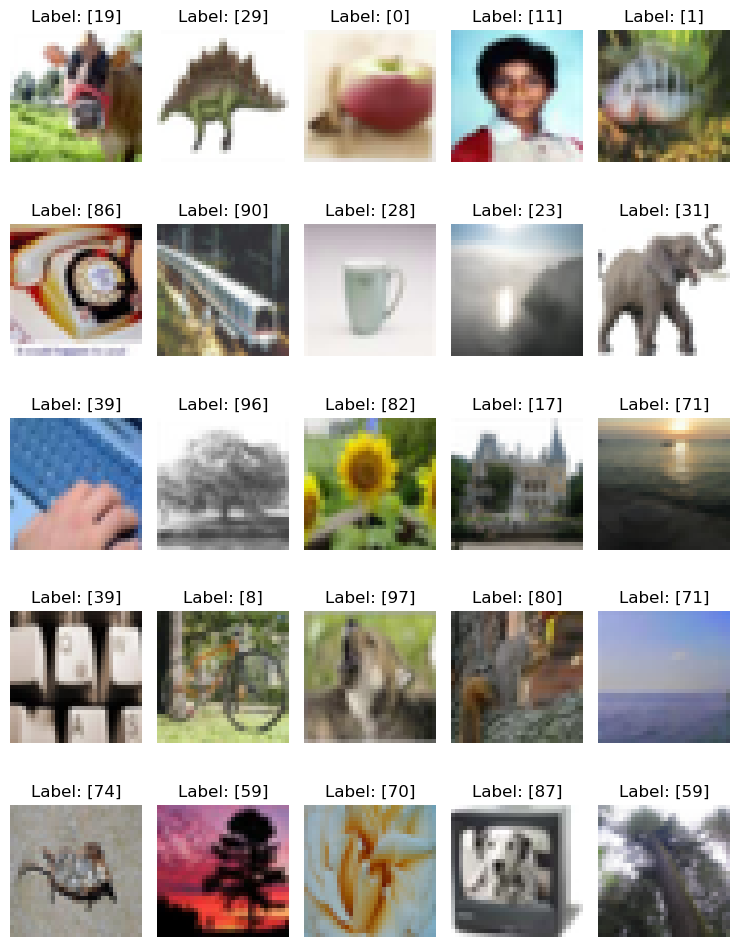

In [5]:
num = 25
images = x_train[:num]
labels = y_train[:num]
num_row = 5
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

# Son todas imagenes opticas capturadas por cámaras

## Preparacion de los datos

In [6]:
# El preprocesamiento lo hacemos a través de una utilidad específica de ResNet50
# pq? los pesos de la red ya fueron adecuados a imagenes que entraban con un 
# preprocesaminto particular para la red.
# Si queremos hacer predicciones o testear la red o hacer transf de aprend, lo ideal
# es hacer el procesamiento de la misma manera con la que fue hecho para la red original

# ENTONCES TENSORFLOW NOS DA PREPROCESS_INPUT
# Podemos reaprovechar los kernels (pesos aprendidos) ya que las imagenes de entrada
# tienen el mismo proceso de preprocesamiento


x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [7]:
# Numero de clases
x_train.shape

(50000, 32, 32, 3)

In [8]:
# Pasamos a formato de one-hot encoding
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

Hacemos un cálculo de cuantos pasos de entrenamiento tendriamos para completar la época. Antes no era necesario pero ahora lo necesitamos como parámero para el input.

In [9]:
steps_per_epoch = int(round(x_train.shape[0]/batch_size))
print(steps_per_epoch)

1562


## Aumentacion de los datos

In [10]:
# Como se inicializa el ImageDataGeneration: aumentacion de datos

datagen = ImageDataGenerator(
            featurewise_center = False,  # set input mean to 0 over the dataset
            samplewise_center = False,  # set each sample mean to 0
            featurewise_std_normalization = False,  # divide inputs by std of the dataset
            samplewise_std_normalization = False,  # divide each input by its std
            zca_whitening = False,  # apply ZCA whitening
            zca_epsilon = 1e-06,  # epsilon for ZCA whitening
            rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range = 0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range = 0.1,
            shear_range = 0.,  # set range for random shear
            zoom_range = 0.,  # set range for random zoom
            channel_shift_range = 0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode = 'nearest',
            cval = 0.,  # value used for fill_mode = "constant"
            horizontal_flip = True,  # randomly flip images
            vertical_flip = False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale = None,
            # set function that will be applied on each input
            preprocessing_function = None,
            # image data format, either "channels_first" or "channels_last"
            data_format = None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split = 0.0)

# Fitiamos el datage con el conjunto de entrenamiento
datagen.fit(x_train)

In [11]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

## Crear el modelo
Creamos la arquitectura de RN a partir de la red original (la ResNet50), modificandola para que se adecue al problema que queremos resolver (cifar100) y vamos a realizar el entrenamiento de esta red.

In [12]:
# ResNet50
# Instanciamos el modelo original de resnet50.
# Los pesos fueron entrenados con un dataset que se llama 'imagenet' que es diferente al datast con el cual estaremos 
# trabajando nosotros.

# Top: la salida de la red en las últimas capas. Capas de redes densas
resnet_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

In [13]:
# Setear las capas de BatchNormalization como entrenables
# Recorremos todo el modelo de resnet, y si esa capa es de BatchNormalization entones la seteamos como entrenable

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

- El modelo es secuencial, porque se introducen las capas secuencialmente ==> no hay que decir cuál es la capa de entrada.
- Está la capa de entrada (todo normal)
- Recordemos que teniamos capas de (32 pix))$\times$(32 pix))$\times$(3 canales). ResNet lo que recibe son imagenes de 256)$\times$256 entonces hay que incluir las capas de upsampling. Cada capa de upsampling lo que hace es duplicar el tamaño de la imagen
- Capa del modelo completo de ResNet (todo el modelo)
- Las apas de bathchnormalization se inicializan con los parametros que vienen del entrenamiento original, que luego se van a ir ajustando
- La salida convulacional 

In [14]:
model = Sequential()
model.add(Input(shape=x_train.shape[1:]))
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D()) # nos quedamos con el valor + significativos
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax')) # Recordar que softmax devuelve una 
                                                  # probabilidad de que tal cosa dependa a una clase

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc', 'mse'])
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 64, 64, 3)         0         
 D)                                                              
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 128, 128, 3)       0         
 g2D)                                                            
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 256, 256, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                

## Entrenar el modelo

In [ ]:
start_time = time.time()

# Método flow
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

history = model.fit(x=x_train,
                    y=y_train,
#                     train_generator,
#                     steps_per_epoch=steps_per_epoch,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=5,
                    shuffle=True,
                    verbose=1)

end_time = time.time()

print('\nElapsed Convolutional Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/5
1563/1563 [==============================] - 78903s 50s/step - loss: 1.7317 - acc: 0.5453 - mse: 0.0059 - val_loss: 0.9594 - val_acc: 0.7130 - val_mse: 0.0039
Epoch 2/5
  57/1563 [>.............................] - ETA: 5:02:14 - loss: 1.0290 - acc: 0.7072 - mse: 0.0041

## Guardar el modelo

In [ ]:
model.save('./src/ResNet50_cifar100.h5')